## Trabajo Práctico: Red Neuronal Lineal.

Nota: aca en el notebook usamos algunas funciones como @, qr, de NP solo para comparar con
los resultados correctos (calculados con numpy). Las soluciones a todos los sistemas verdaderos y las implementaciones de 
todas las funciones nuestras implementan cada una de estas operaciones a mano. 

Lo que si, usamos las funciones np.sum, np.min, np.max para poder vectorizar cuentas que si no tardaban mucho, 
como prodint() que se usa en nuestra multiplicacion de matrices

In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.ticker import FormatStrFormatter
import os
import time

sys.path.append(".")
sys.path.append("./TP")
from alc import *



np.set_printoptions(precision=3, linewidth=150, suppress=True)

os.getcwd()[-3:]
tol = 0.01



Cargamos el dataset

Recordamos, los "t" son los valores de entrenamiento, y los v son los de testeo

In [2]:
Xt, Yt, Xv, Yv = cargarDataset("cats_and_dogs") 
#Xt, Yt, Xv, Yv =  cargarDatasetReducido("cats_and_dogs", 500, 500)
print(Xt.shape)
print(Xv.shape)
print(Yt[:,:3], Yt.shape)
print(Yt[:,:3], Yv.shape)

(1536, 2000)
(1536, 1000)
[[0 0 0]
 [1 1 1]] (2, 2000)
[[0 0 0]
 [1 1 1]] (2, 1000)


In [3]:
cache_save_enabled = False
cache_load_enabled = True

def cache(calc, name):
    if cache_load_enabled and os.path.isfile(f"{name}.npy"):
        return np.load(f"{name}.npy", allow_pickle=True)
    else:
        val = calc()
        if cache_save_enabled:
            np.save(f"{name}.npy", val, allow_pickle=True)
        return val

def cache_many(calc, names):
    if cache_load_enabled and all([os.path.isfile(f"{name}.npy") for name in names]):
        return tuple([cache(lambda:None, name) for name in names])
    else:
        vals = calc()
        for name, val in zip(names, vals):
            cache(lambda:val, name)
        return vals
    
# no quiero perder horas de computo pq fallo un assert, armo esto para que si "Fallaría" el assert te avisa
def pseudoAssertEquality(X,Y, atol = tol):
    try:
        assert np.allclose(X,Y, atol=tol)
    except:
        print("ERROR: Necesita tolerancia ", np.max(np.abs(X-Y)))
    

### QR
Tuvimos que cambiar la funcion de QR del labo para que acepte matrices no cuadradas.
  
Queremos no tener que volver a hacer cuentas muy largas mientras testeamos. QR por GS no es lento asi que no es tan necesario, pero lo hacemos empezando aca por consistencia

#### Por Gram schmidt

In [4]:
tiempogs = datetime.now()
Q, R = cache_many(lambda: QR_con_GS(traspuesta(Xt)), ["QGS", "RGS"])

WGS = cache(lambda:pinvGramSchmidt(Q,R,Yt), "WGS")

YvProbabilidadesGS = cache(lambda:matmul(WGS, Xv), "YvEsperadosGS")




In [5]:
tiempofinalgs = datetime.now()
# compotamiento extraño si cacheas algo que no es una lista
tiempototalgs = cache(lambda: np.array([tiempofinalgs - tiempogs]), "tiempototalGS").item()
print("Tardo:", (tiempofinalgs-tiempogs).seconds, "segundos")

Tardo: 0 segundos


In [6]:

# verificamos que 
# pseudoAssertEquality(Q @ R, traspuesta(Xt), atol=tol) # lo hago con @ solo aca para probar

## comparemos con funcion numpy por si a caso
QNP,RNP = cache_many(lambda: np.linalg.qr(traspuesta(Xt)), ["QNP", "RNP"])

Nump=True
YvProbabilidadesNPQR = cache(lambda:pinvGramSchmidt(QNP,RNP,Yt) @ Xv, "YvEsperadosNPQR")
Nump=False

pseudoAssertEquality(YvProbabilidadesGS,  YvProbabilidadesNPQR, atol=tol)




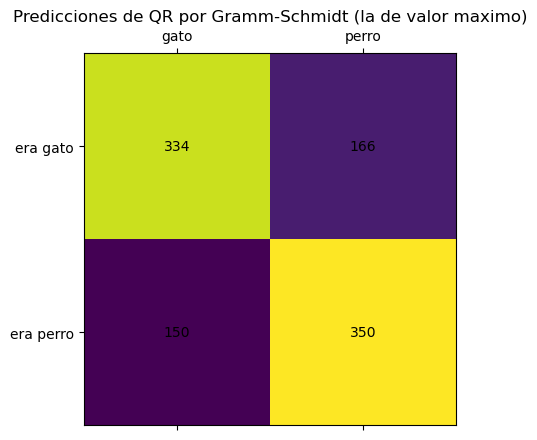

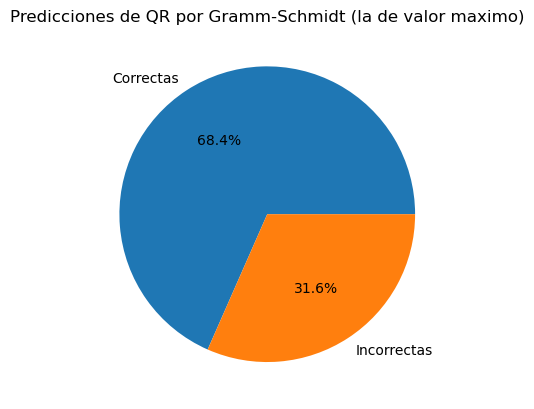

In [7]:
# medio feo tener un choclo de codigo aca pero peor era tener que importar matplotlib en ALC.py  
def graficar_predicciones_de_metodo(nombre_metodo, predicciones, valores_reales):
    gato = [1,0]
    perro = [0,1]


    posibilidadesNombres = ["gato", "perro"]
    confusion2 = np.zeros((2,2))
    for prediccion, valorCorrecto in zip(  traspuesta(predicciones) , traspuesta(valores_reales) ):
        indiceY = int(1-valorCorrecto[0])
        indiceX = int(max(prediccion) == prediccion[1])
        confusion2[ indiceY ][ indiceX ] += 1

    
    
    plt.matshow(confusion2)
    plt.title(f"Predicciones de {nombre_metodo} (la de valor maximo)")
    plt.xticks(range(len(posibilidadesNombres)), posibilidadesNombres)
    plt.yticks(range(len(posibilidadesNombres)), ["era "+n for n in posibilidadesNombres ])
    
    for i ,row in enumerate(confusion2):
        for j ,val in enumerate(row):
            plt.text(j, i, f"{int(val)}", ha="center", va="center", color="black") 
    plt.show()
    pie(confusion2, nombre_metodo + " (la de valor maximo)")

    return confusion2


def pie(confusion, nombre_metodo):
    correcto = 0
    incorrecto = 0
    for i in range(len(confusion)):
        correcto += confusion[i][i]

    incorrecto = len(Xv[0]) - correcto
    plt.pie([correcto, incorrecto], labels=["Correctas", "Incorrectas"], autopct='%1.1f%%')
    plt.title(f"Predicciones de {nombre_metodo}")
    plt.show()

confusionGS = graficar_predicciones_de_metodo("QR por Gramm-Schmidt", YvProbabilidadesGS, Yv)

#### Por HH

In [8]:
tiempohh = datetime.now()

QHH, RHH = cache_many(lambda: QR_con_HH(traspuesta(Xt)), ["QHH", "RHH"])
WHH = cache(lambda:pinvHouseHolder(QHH,RHH,Yt), "WHH")
YvProbabilidadesHH = cache(lambda:matmul(WHH, Xv), "YvEsperadosHH")




In [9]:

tiempofinalhh = datetime.now()
tiempototalhh = cache(lambda: np.array([tiempofinalhh - tiempohh]), "tiempototalHH").item()
print("Tardo:", (tiempofinalhh-tiempohh).seconds, "segundos")

pseudoAssertEquality(YvProbabilidadesHH,  YvProbabilidadesNPQR, atol=tol)

Tardo: 0 segundos


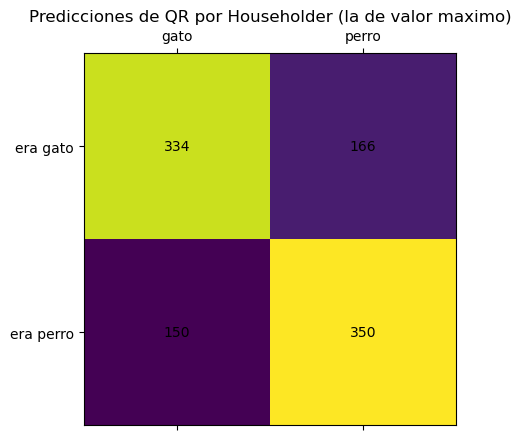

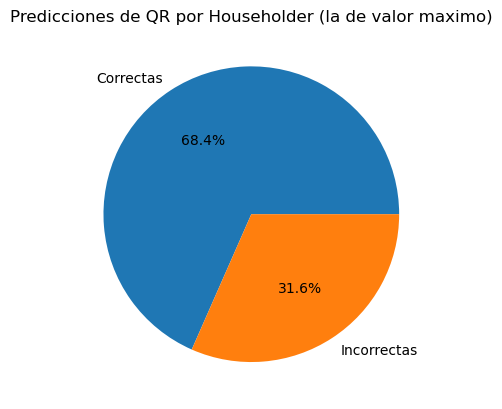

In [10]:
confusionHH = graficar_predicciones_de_metodo("QR por Householder", YvProbabilidadesHH, Yv)


### SVD

In [11]:
tiemposvd = datetime.now()

U,S,V = cache_many(lambda: svd_reducida(Xt, tol=tol), ["U","S","V"])

# svd_reducida, como pide su enunciado, devuelve un vector en S. pero pinvSVD tiene que tomar una matriz. 
# generamos la matriz SM
def diagFrom(list, shape):
    res = np.zeros(shape)
    for i,item in  enumerate(list):
        res[i][i] = item
    return res

 

WSVD = cache(lambda:pinvSVD(U,diagFrom(S, Xt.shape),V,Yt), "WSVD")

YvProbabilidadesSVD = cache(lambda:matmul(WSVD, Xv), "YvEsperadosSVD")


In [12]:
tiempofinalsvd = datetime.now()
tiempototalsvd = cache(lambda: np.array([tiempofinalsvd - tiemposvd]), "tiempototalSVD").item()

print("Tardo:", (tiempofinalsvd-tiemposvd).seconds, "segundos")

Tardo: 0 segundos


In [13]:


print(f"W: {np.round(WSVD,3).shape}")
# pseudoAssertEquality(U @ np.diag(S) @ traspuesta(V), Xt, atol=tol)

print(YvProbabilidadesSVD)
print(Yv)

# Generamos un SVD usando numpy para comparar que tan diferente queda comparada con la nuestra 
UNP,SNP,VNP= cache_many(lambda: np.linalg.svd(Xt), ["UNP","SNP","VNP"])
VNP = VNP.T[:,:Xt.shape[0]]

Nump=True
WSVDNP = cache(lambda:pinvSVD(UNP,diagFrom(SNP, Xt.shape),VNP,Yt), "WSVDNP")
YvProbabilidadesSVDNP = cache(lambda:WSVDNP @ Xv, "YvEsperadosSVDNP")
Nump=False

pseudoAssertEquality(YvProbabilidadesSVD, YvProbabilidadesSVDNP, atol=tol)



W: (2, 1536)
[[-0.162  0.032 -0.244 ...  0.351  2.504  0.378]
 [ 0.895  0.387  1.351 ...  0.567 -0.595  0.286]]
[[0 0 0 ... 1 1 1]
 [1 1 1 ... 0 0 0]]
ERROR: Necesita tolerancia  0.2692662636316564


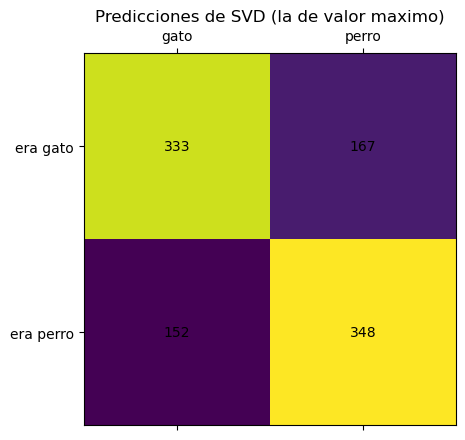

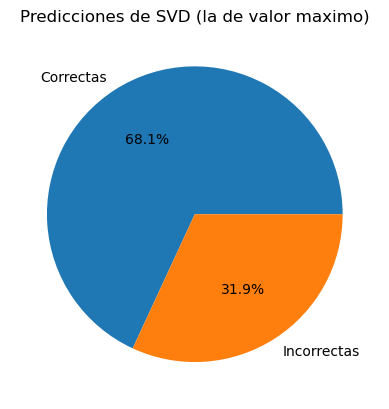

In [14]:
confusionSVD = graficar_predicciones_de_metodo("SVD", YvProbabilidadesSVD, Yv)

### Cholesky / Ecuaciones Normales

In [15]:
tiempoeq= datetime.now()

LCholesky = cache(lambda: cholesky(matmul(Xt, traspuesta(Xt))), "LCholesky")

WEqNorm = cache(lambda:pinvEcuacionesNormales(Xt,LCholesky,Yt), "WEN")

YvProbabilidadesEqNorm = cache(lambda:matmul(WEqNorm, Xv), "YvEsperadosEqNorm")






In [16]:
tiempofinaleq = datetime.now()
tiempototaleq = cache(lambda: np.array([tiempofinaleq - tiempoeq]), "tiempototalEQ").item()
print("Tardo:", (tiempofinaleq-tiempoeq).seconds, "segundos")

Tardo: 0 segundos


In [17]:

print(f"W: {np.round(WEqNorm,3).shape}")
# pseudoAssertEquality(LCholesky @ traspuesta(LCholesky), matmul(Xt, traspuesta(Xt)), atol=tol)

print(YvProbabilidadesEqNorm)
print(Yv)

# comparamos con el resultado de hacerlo con numpy
LCholeskyNP = cache(lambda:  np.linalg.cholesky(Xt @ Xt.T), "LCholeskyNP")

Nump=True
WWEqNormNP = cache(lambda:pinvEcuacionesNormales(Xt, LCholeskyNP, Yt), "WENNP")
YvProbabilidadesEqNormNP = cache(lambda:WWEqNormNP @ Xv, "YvEsperadosEqNormNP")
Nump=False


W: (2, 1536)
[[-0.253  0.005 -0.255 ...  0.402  2.461  0.403]
 [ 1.027  0.345  1.371 ...  0.507 -0.557  0.306]]
[[0 0 0 ... 1 1 1]
 [1 1 1 ... 0 0 0]]


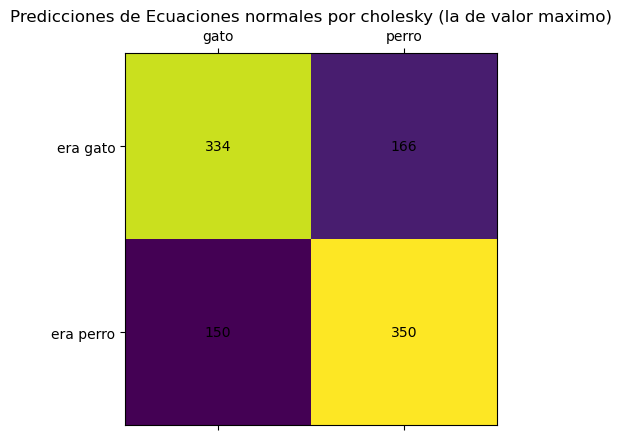

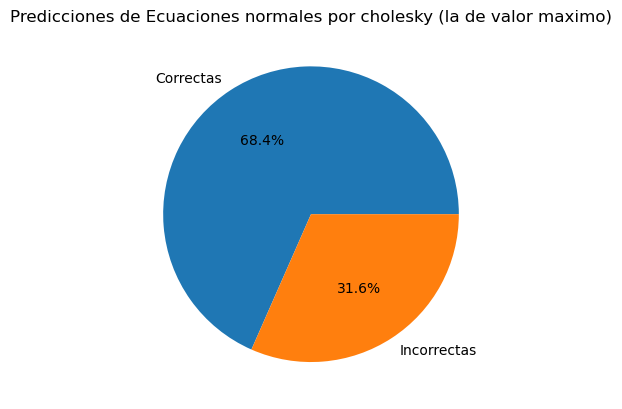

In [18]:
confusionEQ = graficar_predicciones_de_metodo("Ecuaciones normales por cholesky", YvProbabilidadesEqNorm, Yv)

In [19]:
difProbabilidadesGR=np.max(np.abs(YvProbabilidadesGS-YvProbabilidadesNPQR))
difProbabilidadesHH=np.max(np.abs(YvProbabilidadesHH-YvProbabilidadesNPQR))
difProbabilidadesEqNorm=np.max(np.abs(YvProbabilidadesEqNorm-YvProbabilidadesEqNormNP))
difProbabilidadesSVD=np.max(np.abs(YvProbabilidadesSVD-YvProbabilidadesSVDNP))

avgDifProbabilidadesGR=np.average(np.abs(YvProbabilidadesGS-YvProbabilidadesNPQR))
avgDifProbabilidadesHH=np.average(np.abs(YvProbabilidadesHH-YvProbabilidadesNPQR))
avgDifProbabilidadesEqNorm=np.average(np.abs(YvProbabilidadesEqNorm-YvProbabilidadesEqNormNP))
avgDifProbabilidadesSVD=np.average(np.abs(YvProbabilidadesSVD-YvProbabilidadesSVDNP))

exactitudGs = (confusionGS[0][0]+confusionGS[1][1])/(confusionGS[0][0]+confusionGS[1][1] + confusionGS[0][1]+confusionGS[1][0])
exactitudHh = (confusionHH[0][0]+confusionHH[1][1])/( confusionHH[0][0]+confusionHH[1][1] + confusionHH[0][1]+confusionHH[1][0])
exactitudSvd = (confusionSVD[0][0]+confusionSVD[1][1])/(confusionSVD[0][0]+confusionSVD[1][1] + confusionSVD[0][1]+confusionSVD[1][0])
exactitudEq = (confusionEQ[0][0]+confusionEQ[1][1])/(confusionEQ[0][0]+confusionEQ[1][1] + confusionEQ[0][1]+confusionEQ[1][0])


#difPseudoInvGR=normaMatMC(PGS-PGSNump)
#difPseudoInvHH=normaMatMC(PHH-PGSNump)
#difPseudoInvSVD=normaMatMC(PSVD-PSVDNump)
#difPseudoInvEqNorm=normaMatMC(PEqNorm-PEqNormNump)

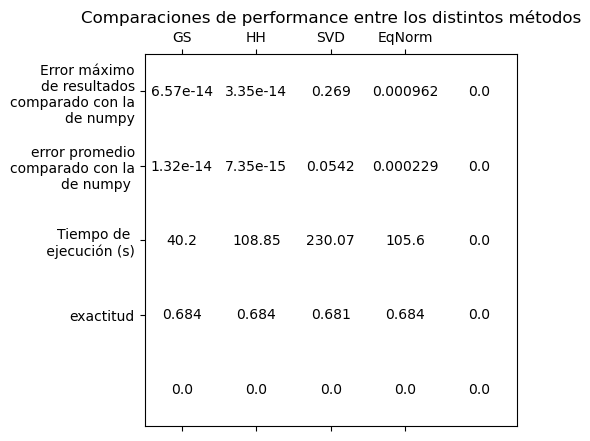

In [20]:
data=np.zeros((5,5))

# for i in data:
#     for j in data:
#         data[i][j]=

data[0][0]=f"{difProbabilidadesGR:.2e}"
data[0][1]=f"{difProbabilidadesHH:.2e}"
data[0][2]=f"{difProbabilidadesSVD:.2e}"
data[0][3]=f"{difProbabilidadesEqNorm:.2e}"

data[1][0]=f"{avgDifProbabilidadesGR:.2e}"
data[1][1]=f"{avgDifProbabilidadesHH:.2e}"
data[1][2]=f"{avgDifProbabilidadesSVD:.2e}"
data[1][3]=f"{avgDifProbabilidadesEqNorm:.2e}"

data[2][0]=f"{tiempototalgs.seconds + tiempototalgs.microseconds * 0.000001:.2f}"
data[2][1]=f"{tiempototalhh.seconds+ tiempototalhh.microseconds * 0.000001:.2f}"
data[2][2]=f"{tiempototalsvd.seconds+ tiempototalsvd.microseconds * 0.000001:.2f}"
data[2][3]=f"{tiempototaleq.seconds+ tiempototaleq.microseconds * 0.000001:.2f}"

data[3][0]=f"{round(exactitudGs,4)}"
data[3][1]=f"{round(exactitudHh,4)}"
data[3][2]=f"{round(exactitudSvd,4)}"
data[3][3]=f"{round(exactitudEq,4)}"

#data[4][0]=f"{round(difPseudoInvGR,4)}"
#data[4][1]=f"{round(difPseudoInvHH,4)}"
#data[4][2]=f"{round(difPseudoInvSVD,4)}"
#data[4][3]=f"{round(difPseudoInvEqNorm,4)}"



plt.matshow(data, cmap=matplotlib.colors.ListedColormap(['white']))
plt.title(f"Comparaciones de performance entre los distintos métodos")
plt.xticks(range(4), ["GS", "HH", "SVD", "EqNorm"])
plt.yticks(range(4), [
"""Error máximo
de resultados
comparado con la
de numpy""", 
"""
error promedio
comparado con la
de numpy 
""", 
"Tiempo de \n ejecución (s)",
 "exactitud"
])

for i ,row in enumerate(data):
    for j ,val in enumerate(row):
        plt.text(j, i, f"{val}", ha="center", va="center", color="black") 

plt.show()

# table = tabulate(
#     data, 
#     headers=["GS", "HH", "SVD", "EQNORM"], 
#     tablefmt="grid"
# )

# print(table)


# Informe del Trabajo Práctico
Integrantes:


 - Juan Ignacio Pubill- LU: 120/24
 - Leandro Ernesto Horane Siracusa - LU: 408/24
 - Ramiro Gantman - LU: 1120/24
 - Jeremías José Mannino - LU: 611/24

## Consideraciones tomadas

Todos los algoritmos utilizados para el cálculo de la pseudoinversa, se pudieron optimizar mediante vectorización, aprovechando los cálculos de la biblioteca numpy al hacer slicing, np.sum(), min, max etc. Nunca usamos funciones como @, .T, y otras dentro del código principal. En el notebook aparecen algunas veces para testear, pero nunca para calcular las cosas que pedía en en enunciado del TP.

## Resultados experimentales y analisis
Como medida de performance se utilizó la exactitud, la cual se mide como $$(TP + TN)/(P + N)$$  
Como se observa en la tabla comparativa de performance, Los tiempos de ejecución fueron bastante aceptables, considerando que estan escritos en un lenguaje generalmente lento como python y comparándo con el tiempo que tardaban los métodos sin optimización.
Normalmente se esperaría el siguiente orden de tiempos en calcular según los diferentes métodos:
$$ \text{Ecuaciones normales} < \text{QR por HH} < \text{QR por GS} < \text{SVD} $$
Sin embargo, en la tabla anterior podemos ver que nuestros resultados fueron diferentes. Creemos que este se debe principalmente a que algunos métodos se pueden vectorizar mas en la implementación de python con numpy usando las funciones que tenemos permitidas y otros menos.  
En esa misma tabla, se puede notar que las exactitudes son muy similares entre si, 3 de las 4 iguales. Lo sorprendente es que un de los calculos dio suficientemente diferente al resto (recordar que la pseudoinversa es única) para que haya una predicción diferente, y más aún, es el de SVD, que se suponía que era el más estable. 
También se tomó el máximo de las diferencias entre las probabilidades predichas por nuestro modelo y el modelo de numpy, en donde se ven variaciones más acentuadas.
A su vez, la precisión de los 4 métodos es cercana al 70%, lo cual parece ser no tan bueno, pero depende del uso que se le quiera dar.
Tambien, a medida que se va aumentando el, número de datos que se tienen en cuenta del dataset original, la precisión se va acercando al 70%.
Esto se cumple para todos los métodos.
Si se observan las matrices de confusión de cada método, se puede concluir que el modelo predice más perros que gatos, por ende se tiene un mayor acierto de perros pero también un mayor error de perros.
A su vez, pareciera que el modelo tiene más perros que gatos, y por eso el modelo adopta esa tendencia. 
Si nos basamos tanto en precisión como en exactitud, SVD es el meétodo que mejor performance tiene (apenas notable la diferencia con el resto), mientras que los demás, al redondearse, quedan iguales.  
Si nos basamos en tiempo de ejecución, el merjor método es